In [ ]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import ipywidgets as widgets
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# Color set of cover arts images

subset_cols = ['black', 'gray', 'silver', 'white', 'maroon', 'red', 'orange', 'yellow', 'olive',
            'green', 'lime', 'teal', 'cyan', 'navy', 'blue', 'purple', 'pink']

Well, for analysis, I need some functions that will make it easier to understand many key points. They are presented below:

In [ ]:
# Main useful functions for further analysis

def plot_genre_colors(df, genre, ax, fontsize=12):
    """
    Plot a bar chart showing the percentage of colors in book covers for a given genre.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the book cover color data.
    genre (str): The genre to plot.
    ax (matplotlib.axes.Axes): The subplot axes to use for the plot.
    fontsize (int, optional): The font size for text in the plot. Defaults to 9.
    """
    subset=subset_cols
    
    df_ = df[df['genres'].str.contains(genre)]
    df_.drop_duplicates(subset=['cover'], keep='first', inplace=True)
    means = pd.DataFrame(df_[subset].mean(), columns=['mean']).T
    
    # convert means to percentages
    means = means.apply(lambda x: x * 100)
    
    # plot the bar chart
    colors = ['black', 'gray', 'silver', (0.95, 0.95, 0.95), 'maroon', 'red', 'orange', 'yellow', 'olive',
            'green', 'lime', 'teal', 'cyan', 'navy', 'blue', 'purple', 'pink']
    ax.bar(means.columns, means.iloc[0], width=0.7, color=colors)
    
    # add data labels to the bars
    for i, v in enumerate(means.iloc[0]):
        ax.text(i, v+0.5, f'{v:.1f}%', ha='center', fontsize=fontsize)
    
    ax.set_title(f'Average share of colors in {genre.title()} covers palette', fontsize=fontsize+2)
    ax.set_xlabel('Color', fontsize=fontsize)
    ax.set_ylabel('Percentage', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_ylim([0, 30])
    
    return ax


def max_color_rows(df: pd.DataFrame, color: str):
    """
    Given a pandas DataFrame and a color column name, returns a DataFrame with the rows that have the maximum value in
    the color column.

    Args:
    - df: pandas.DataFrame: The DataFrame to be processed.
    - color: str: The name of the column to be used to calculate the maximum value.

    Returns:
    - pandas.DataFrame: A DataFrame with the rows that have the maximum value in the color column, along with the 'title',
    'all_artists', 'cover', and color columns.
    """
    # Find the index of the row with the maximum value in the color column
    max_ = df[color].idxmax()
    # Select all rows that have the same value as the maximum value in the color column
    max_rows = df.loc[df[color] == df.loc[max_, color]]
    # Select only the 'title', 'all_artists', 'cover', and color columns
    max_rows = max_rows[['title', 'all_artists', 'cover', color]]
    # Return the resulting DataFrame
    return max_rows


def path_to_image_html(path: str) -> str:
    """
    Given a path to an image file, returns an HTML <img> tag with the specified path as the 'src' attribute.

    Args:
    - path: str: The path to the image file.

    Returns:
    - str: An HTML <img> tag with the specified path as the 'src' attribute and a width of 60 pixels.
    """
    # Create the HTML <img> tag with the specified path as the 'src' attribute and a width of 60 pixels
    html = '<img src="' + path + '" width="60" >'
    # Return the resulting HTML tag
    return html


def display_dataframe(df, num_rows=100):
    """
    Given a pandas DataFrame and an optional number of rows, returns an HTML table that displays the first n rows of the
    DataFrame, where n is the value of the 'num_rows' argument.

    Args:
    - df: pandas.DataFrame: The DataFrame to be displayed.
    - num_rows: int: The number of rows to be displayed. Defaults to 100.

    Returns:
    - IPython.core.display.HTML: An HTML table that displays the first n rows of the DataFrame, where n is the value of
    the 'num_rows' argument.
    """
    # Convert the first n rows of the DataFrame to an HTML table, using the path_to_image_html() function to display image data
    html_table = df.head(num_rows).to_html(escape=False, formatters=dict(cover=path_to_image_html))
    # Return the resulting HTML table wrapped in an IPython display object
    return HTML(html_table)


def show_images(df, sample_size):
    # Select a random sample of rows from the DataFrame
    sample = df.sample(sample_size)

    # Convert the 'cover' column values to HTML img tags using the path_to_image_html() function
    images = [path_to_image_html(url) for url in sample['cover'].values]

    # Join the list of HTML img tags into a single string and wrap it in an HTML display object
    images_display = HTML(''.join(images))

    # Display the HTML display object
    display(images_display)



def show_covers_clusters(df):
    """
    Given a pandas DataFrame 'df' containing cover image paths and a 'cluster' column indicating cluster membership, displays
    a set of HTML widgets using the 'show_images()' function for each cluster, and prints the number of covers in each cluster.

    Args:
    - df: pd.DataFrame: A DataFrame containing cover image paths and a 'cluster' column indicating cluster membership.

    Returns:
    - None
    """
    # Iterate over each unique cluster in the 'cluster' column of the DataFrame
    for i in range(0, len(df['cluster'].unique())):
        # Select the subset of the DataFrame corresponding to the current cluster
        subset = df[df['cluster'] == i]
        # Print the cluster number and the number of covers in the current subset
        print()
        print(f'cluster № {i}, covers quantity: ', len(subset))
        # Display a set of HTML widgets using the 'show_images()' function for the current subset
        show_images(subset, sample_size=100)

    return


def analyze_cluster_chars(means_df, mode='max'):
    """
    Given a pandas DataFrame 'means_df' containing mean values of character features for each cluster and a mode ('max' or 'min'),
    determines the cluster with the highest or lowest mean value for each character feature, creates a dictionary containing the
    cluster numbers for each feature, and prints the characteristics info and displays a set of HTML widgets using the 'show_images()'
    function for each cluster.

    Args:
    - means_df: pd.DataFrame: A DataFrame containing mean values of character features for each cluster.
    - mode: str: A string indicating whether to search for the cluster with the highest ('max') or lowest ('min') mean value for each feature.

    Returns:
    - None
    """
    # Determine the cluster with the highest or lowest mean value for each character feature, depending on the mode argument
    if mode == 'max':
        _clusters = means_df.idxmax()
        _clusters = pd.DataFrame(_clusters, columns=['cluster'])
        _clusters = _clusters.rename(index=lambda x: 'max '+x)
        char_dict = _clusters.to_dict(orient='index')
    elif mode == 'min':
        _clusters = means_df.idxmin()
        _clusters = pd.DataFrame(_clusters, columns=['cluster'])
        _clusters = _clusters.rename(index=lambda x: 'min '+x)
        char_dict = _clusters.to_dict(orient='index')
    else:
        raise ValueError(f"Invalid mode '{mode}', mode must be 'max' or 'min'")

    # Iterate over the dictionary containing the cluster numbers for each feature, printing the info and displaying a set of HTML widgets for each cluster
    for k, v in char_dict.items():
        print()
        print(k, '-->', 'cluster №', v['cluster'])
        subset = union_df[union_df['cluster'] == v['cluster']]
        show_images(subset, sample_size=36)

    return


def plot_colors_linechart(df: pd.DataFrame, subset: list, line_colors: list, start_year: int, y_max_value: float) -> None:
    """
    Creates a line chart showing the mean color values of the specified subset of columns from a DataFrame grouped by year of
    release date, starting from a specified year.
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the data to be plotted.
    - subset (list): A list of column names to be included in the plot.
    - line_colors (list): A list of color names to be used for each line in the plot.
    - start_year (int): The year from which to start plotting data.
    - y_max_value (float): The maximum value on the y-axis.

    Returns:
    - None: Displays the plot.
    """
    df = df[subset]

    # convert the release_date column to a datetime object
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # drop rows with out of bounds datetime values
    df = df.dropna(subset=['release_date'])

    # extract the year from the release_date column and create a new column for it
    df['year'] = df['release_date'].dt.year
    df = df[df['year'] > start_year]

    # group the data by year and calculate the mean of each color column
    grouped = df.groupby('year').mean()

    # create a function to format the y ticks as percentages
    def percentage(x, pos):
        return '{:.0%}'.format(x)

    # create a line plot of the grouped data with colors
    ax = grouped.plot(kind='line', ylim=[0, y_max_value], title='Mean color values by year', figsize=(20, 10), color=line_colors)

    # format the y ticks as percentages using the percentage() function
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(percentage))

    # add labels for the x and y axes
    plt.xlabel('Year of release')
    plt.ylabel('Mean color value')
    plt.show()


I will use the dataset that was parsed earlier using the Spotify api for analysis. It contains features for each track, such as acousticness, loudness, danceability of the track, release date, etc. (you can read about these features here: https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features), and color information in the cover palette. In my exploratory analysis, I will focus on the cover arts, or rather on the colors used in them.


In [ ]:
union_df = pd.read_csv('/content/union_df.csv')
union_df

,id,title,all_artists,genres,cover,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_id
0,6H7RUDjmjiGV4I9hE24Kk5,drivers license,jxdn,"pop punk, social media pop",https://i.scdn.co/image/ab67616d00001e0214e2f6...,0.250,0.250,0.250,0.125,0.000,0.125,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,54,2021-01-19,0.598,0.787,10,-4.695,1,0.017500,0.000000,0.0887,0.2980,144.021,237644,4,6Y64EaNqpqcZYTgs4c76gF
1,0we7ShV1o6cPTFjxOADPbC,Outcast,NF,"hip hop, pop rap, rap",https://i.scdn.co/image/ab67616d00001e02cd7339...,0.500,0.375,0.125,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,58,2017-10-06,0.739,0.751,2,-7.161,1,0.165000,0.000000,0.0599,0.3210,130.176,325720,4,6fOMl44jA4Sp5b9PpYCkzz
2,6V81K1OcvYgHEnCA6A2Qx9,Start a Riot,"Duckwrth,Shaboozey","alternative r&b, escape room, indie r&b, pop r...",https://i.scdn.co/image/ab67616d00001e02e2e352...,0.375,0.000,0.250,0.000,0.125,0.125,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.125,0.0,0.000,64,2018-12-14,0.728,0.727,2,-3.585,1,0.012800,0.000000,0.0882,0.8900,143.144,171467,4,"6I3MElirhT5t6Kf7p0hGk9,3y2cIKLjiOlp1Np37WiUdH"
3,37PJvlIfYWqEX6fgjHlnTf,WTF Do I Know,Miley Cyrus,pop,https://i.scdn.co/image/ab67616d00001e028cffb7...,0.375,0.125,0.000,0.125,0.250,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.125,66,2020-11-27,0.564,0.849,4,-2.619,0,0.002550,0.000000,0.2690,0.6340,157.905,171800,4,5YGY8feqx7naU7z4HrwZM6
4,3b2ngmuuJP2XCUUwZvK9WQ,Every Window Is A Mirror,Joywave,"indie poptimism, indietronica, modern alternat...",https://i.scdn.co/image/ab67616d00001e02da0e29...,0.250,0.000,0.375,0.125,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.125,0.000,0.125,0.000,0.0,0.000,33,2021-05-07,0.503,0.667,0,-4.166,1,0.001040,0.000438,0.0991,0.6800,105.033,173227,4,1UfzhwcOR4yfX7yHTPfC9m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85600,3Sksq7o6HcImr02h7DcJRO,"Pokémon League Lo-Fi Remix (From ""Pokémon Diam...",GlitchxCity,"lo-fi vgm, otacore, pixel",https://i.scdn.co/image/ab67616d00001e027ae1fe...,0.000,0.375,0.250,0.125,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.250,0.000,0.000,0.000,0.0,0.000,34,2019-04-30,0.635,0.256,9,-15.890,0,0.111000,0.840000,0.0681,0.5730,160.002,278083,4,0X1wtVNo8CVrMEKh8y8knH
85601,1K0LoLME6kJXWbOL2E5llC,National Park (Lo-Fi Remix),GlitchxCity,"lo-fi vgm, otacore, pixel",https://i.scdn.co/image/ab67616d00001e02dbc48d...,0.000,0.500,0.375,0.125,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,32,2019-03-20,0.663,0.232,1,-18.241,1,0.502000,0.861000,0.1100,0.5330,160.000,240016,4,0X1wtVNo8CVrMEKh8y8knH
85602,6FDobgvIAVY2VflCk2WGpE,Lake Theme (Lo-Fi Remix),GlitchxCity,"lo-fi vgm, otacore, pixel",https://i.scdn.co/image/ab67616d00001e02945a13...,0.000,0.000,0.000,0.250,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.625,0.000,0.125,0.0,0.000,33,2019-03-13,0.407,0.191,5,-21.259,1,0.000347,0.918000,0.1730,0.0785,149.989,283217,4,0X1wtVNo8CVrMEKh8y8knH
85603,5mg6SBqaKolpPPGUIdxG0t,"Undella Town (From ""Pokémon Black and White"")",HoopsandHipHop,"lo-fi vgm, otacore",https://i.scdn.co/image/ab67616d00001e022b859b...,0.000,0.000,0.125,0.000,0.500,0.000,0.375,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0,2017,0.900,0.584,10,-11.299,1,0.013100,0.464000,0.3380,0.0341,140.055,214733,4,6doBPcAt2vxQmvbcmNxMmc


**COLORS IN DIFFERENT GENRES**

Let's examine the distribution of the proportions of colors used in the palette of track covers on average by genre! I`ve chosen some popular genres like: drill, trap, metal, pop punk, edm, k-pop, rock and hip hop and built bar plots for every genre.

In [ ]:
explore_genres = union_df.dropna(subset = 'genres')

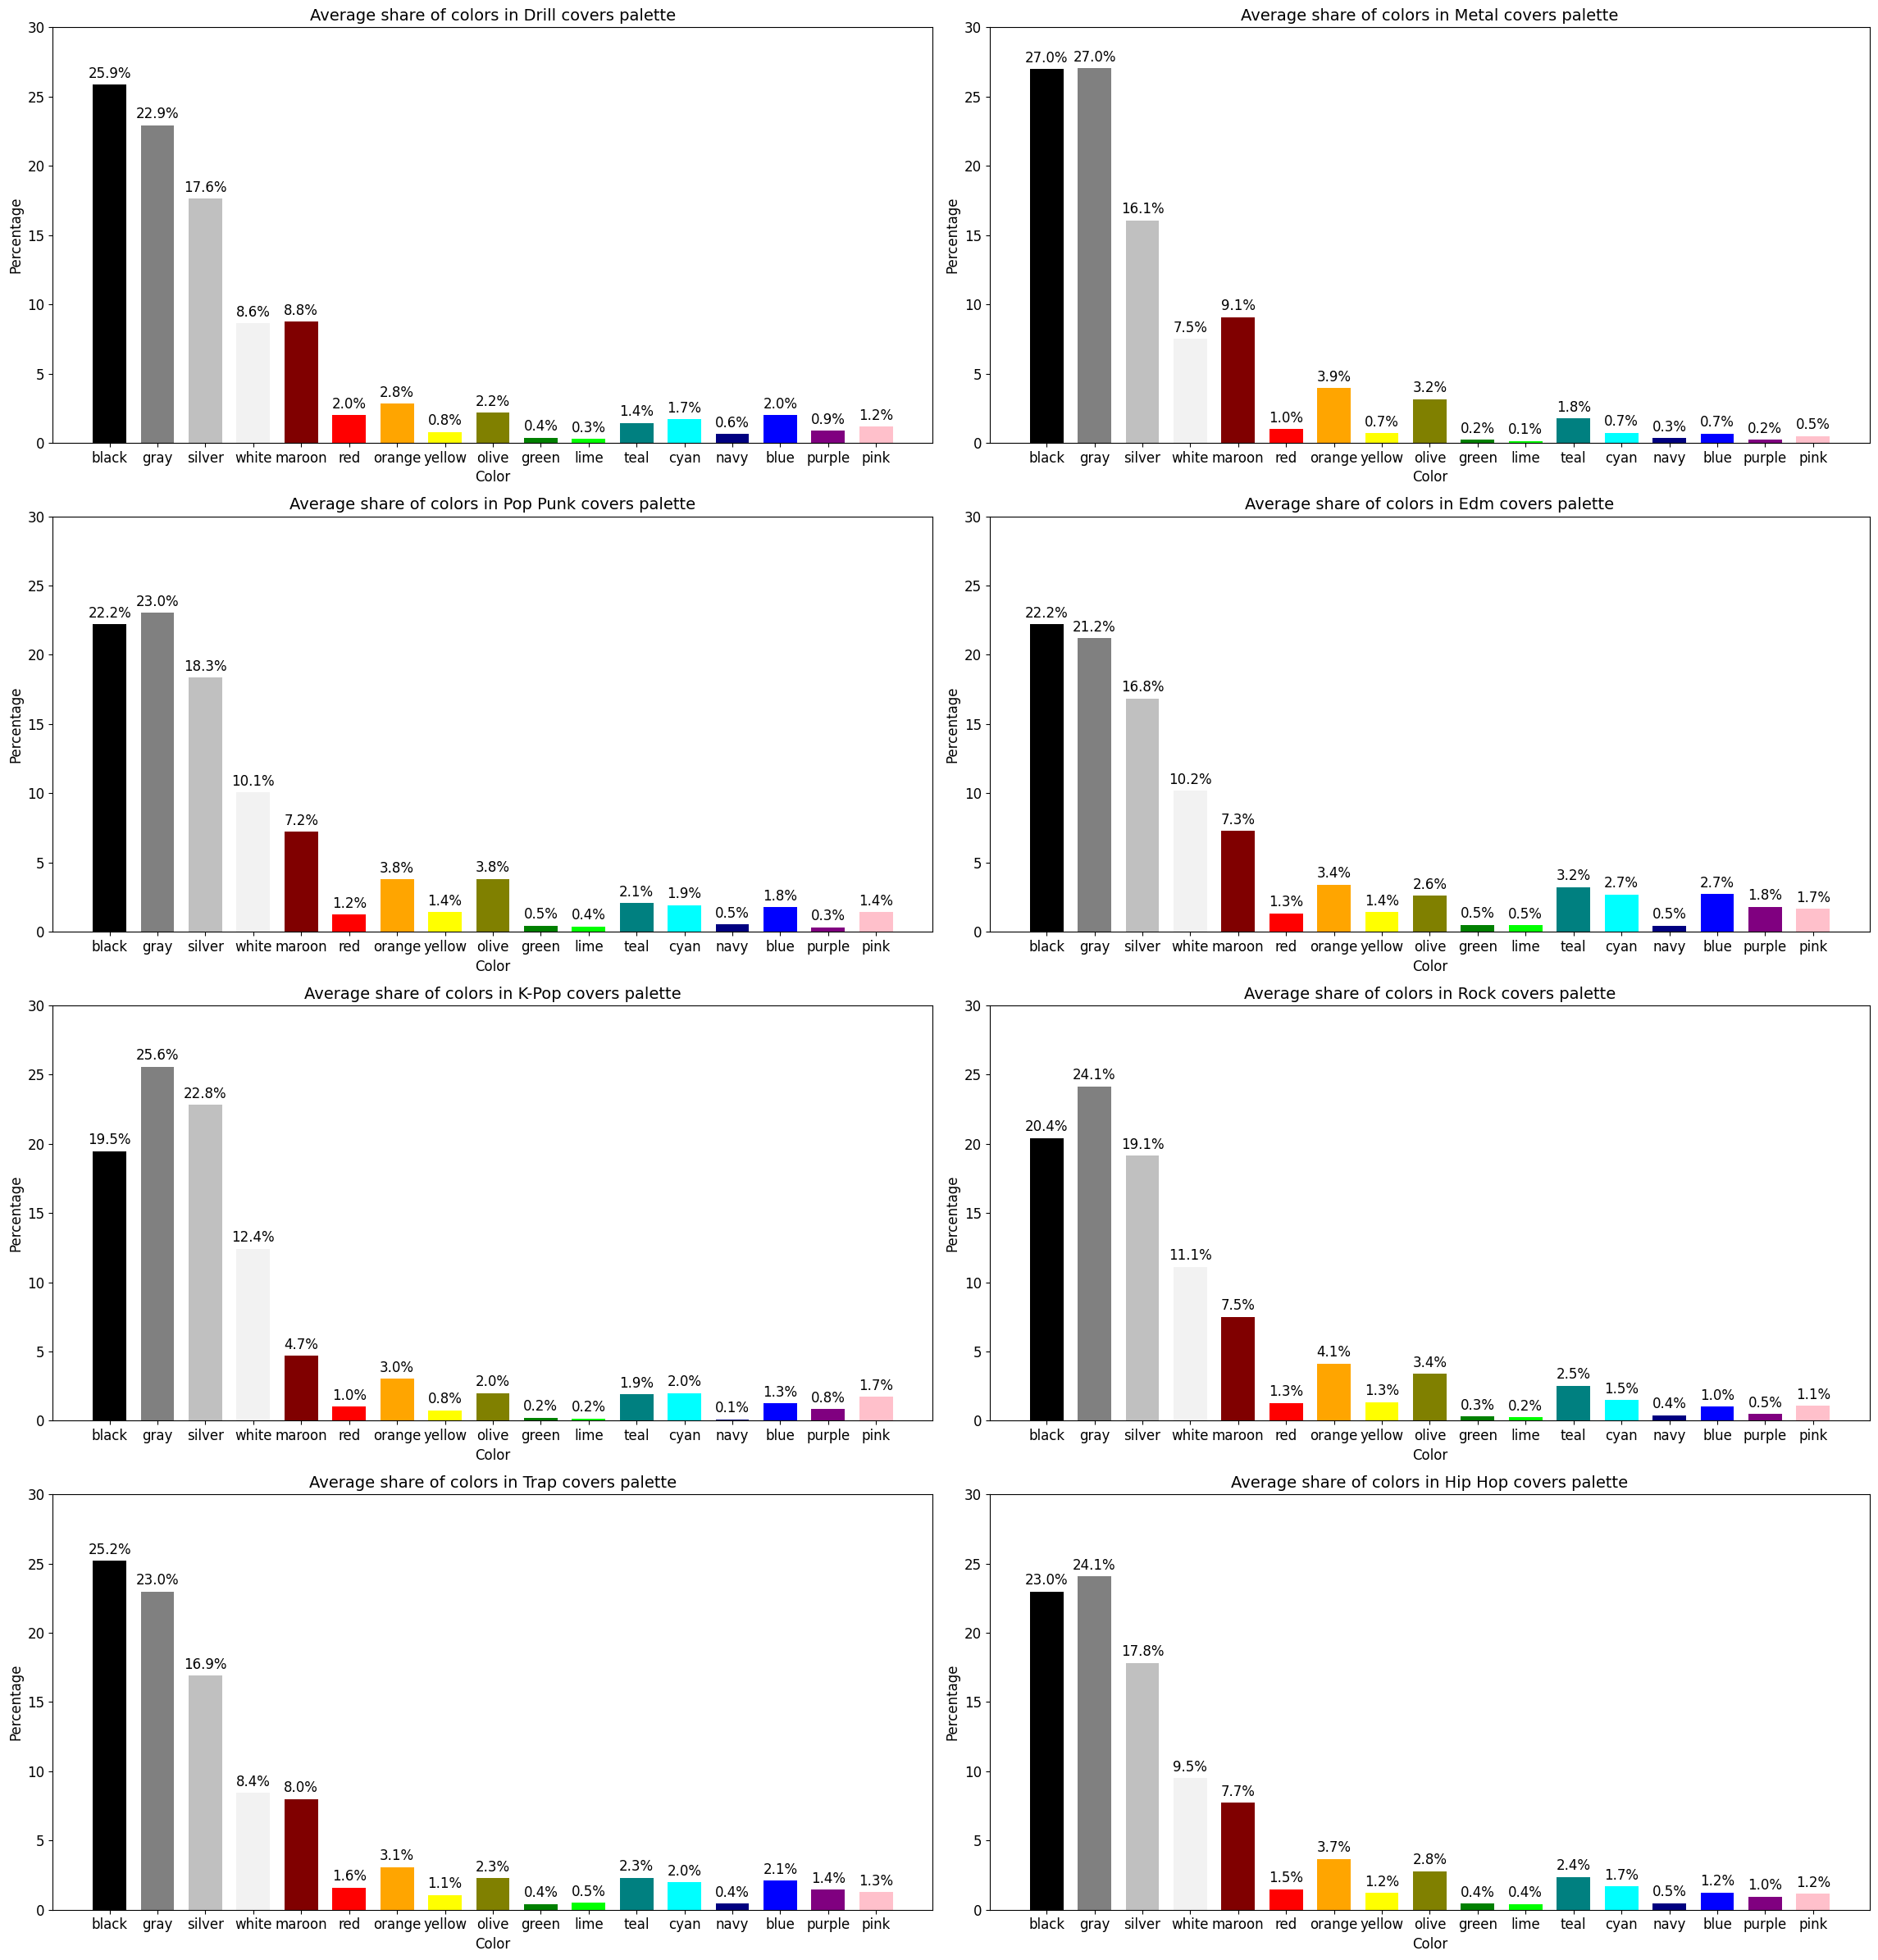

In [ ]:
# Create a list of the genres to plot
genres = ['drill', 'metal', 'pop punk', 'edm', 'k-pop', 'rock', 'trap', 'hip hop']

# Calculate the number of rows and columns needed for the subplots
num_plots = len(genres)
num_cols = 2
num_rows = (num_plots - 1) // num_cols + 1

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(23, 6*num_rows))

# Iterate over the genres and plot them in the subplots
for i, genre in enumerate(genres):
    ax = axs[i // num_cols, i % num_cols]
    plot_genre_colors(explore_genres, genre, ax=ax)
    
# Remove any unused subplots
for i in range(num_plots, num_rows*num_cols):
    fig.delaxes(axs[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show()


We can see black, gray, silver and white are most frequent used colors in cover arts. This may be due both to the wide prevalence of covers with a portrait of the artist on it. Then the color of hair, eyebrows, contours, eyes, etc. things will bring their share of the content of the black on the cover arts. 

The dominance of black, gray, silver, and white colors in Spotify cover arts may also be related to the concept of color contrast. These colors are often used as the background to enhance the contrast of the other elements in the design, such as text or images, or figure of artist. In any case, we see that this distribution does not change from genre to genre, which is consistent with the previous analysis of the correlation of genres and colors used in the cover arts.

Let's forget the genres now and take a look at the most extreme cover representatives of each color:

In [ ]:
max_colors = pd.DataFrame()
for color in subset_cols:
  max_rows = max_color_rows(union_df, color)
  max_colors = max_colors.append(max_rows.sample(1))

max_colors.fillna(0, inplace = True)
display_dataframe(max_colors, 17)


,title,all_artists,cover,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink
44931,Daft Punk - Mashup,"Trinix Remix,Trinix",,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
63695,In a Different Place - 2001 Remaster,Ride,,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
68766,"Avalanche! Oh, Avalanche!",Gregory and the Hawk,,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
45203,While My Guitar Gently Weeps - Remastered,The Beatles,,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
29474,SUMMER AT 7,Russ,,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
30343,UGLY (feat. Lil Baby),"Russ,Lil Baby",,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
81741,rains,sagun,,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
40078,Fyre,Dence,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
42803,Freed Up,Russ,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
44242,HANDSOMER,Russ,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875,0.0,0.0,0.0,0.00,0.0,0.0,0.0


**COVERS CLUSTERING**

Now it would be interesting to see what type of covers is the most common. The K-Means machine learning algorithm will again help with this, which will define the main clusters of covers in my dataset based on the colors used in them. The optimal number of clusters is found using the Elbow Method:

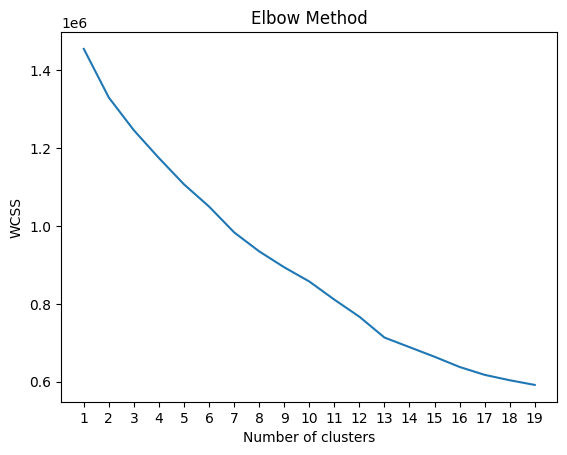

In [ ]:
subset_df = union_df[subset_cols]

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(subset_df)

# Determine the optimal number of clusters
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 20))
plt.show()

# Apply k-means algorithm
num_clusters = 13 # chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(normalized_data)

# Add cluster labels as a new column in the original dataframe
union_df['cluster'] = kmeans.predict(normalized_data)

Using the Elbow Method, I obtained the optimal number of clusters equal to thirteen

Let`s demonstrate typical representatives of each cluster:

In [ ]:
show_covers_clusters(union_df)


cluster № 0, covers quantity:  13582



cluster № 1, covers quantity:  11504



cluster № 2, covers quantity:  30745



cluster № 3, covers quantity:  1242



cluster № 4, covers quantity:  4153



cluster № 5, covers quantity:  2354



cluster № 6, covers quantity:  4920



cluster № 7, covers quantity:  1589



cluster № 8, covers quantity:  4092



cluster № 9, covers quantity:  4929



cluster № 10, covers quantity:  809



cluster № 11, covers quantity:  4366



cluster № 12, covers quantity:  1320


Well, the winner is....cluster 2! The cover arts that belong to this cluster are the most, as many as 30745!

In [ ]:
subset = union_df[union_df['cluster'] == 2]
show_images(subset, sample_size = 100)
means = pd.DataFrame(subset[subset_cols].mean() * 100, columns=['mean']).T
means = means.applymap('{:.1f}%'.format)
means

,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink
mean,16.8%,34.7%,27.7%,14.1%,3.0%,0.0%,1.1%,0.0%,1.0%,0.0%,0.0%,0.8%,0.5%,0.0%,0.3%,0.2%,0.0%


Thus, we can see that the most typical music release cover is made in tones with a predominant content in the palette of gray and silver colors, and to a slightly lesser extent - black and white. Which, in turn, correlates with what we saw on the graphs of the color distribution by genre a little earlier

**TRACKS CHARACTERISTICS AND COVERS**

It's very interesting now to see which cover clusters have the highest mean scores of features provided by Spotify. Let's find out:

In [ ]:
# Main characteristics from Spotify
characteristics = ['popularity', 'cluster',	'danceability',	'energy',	
                   'key',	'loudness',	'mode',	'acousticness',	
                   'instrumentalness',	'liveness',	'valence',	
                   'tempo',	'duration_ms']

# Group the dataframe by the 'cluster' column and calculate the mean of each group
cluster_means = union_df[characteristics].groupby('cluster').mean()

# Print the resulting dataframe
cluster_means

,popularity,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
cluster,,,,,,,,,,,,
0,23.500221,0.522288,0.646483,5.240613,-8.388467,0.606464,0.246063,0.221407,0.205213,0.391142,121.464970,244807.699234
1,24.187935,0.525394,0.660605,5.180024,-8.376619,0.631606,0.243838,0.172816,0.221439,0.441411,121.096777,253642.007476
2,22.569621,0.547085,0.608633,5.234510,-8.959067,0.646251,0.301483,0.192335,0.193504,0.452109,120.923635,234274.211807
3,21.631240,0.589717,0.641671,5.332528,-8.549570,0.657005,0.276982,0.222594,0.207732,0.489143,121.506107,217901.888889
4,21.940043,0.580134,0.617358,5.295690,-8.674629,0.608476,0.277771,0.208160,0.211960,0.476677,121.003789,222092.129304
5,23.567120,0.549417,0.610461,5.269329,-9.284930,0.617247,0.290493,0.190882,0.206592,0.450650,119.335791,237343.745964
6,20.376423,0.556046,0.626337,5.347154,-9.194996,0.654878,0.291325,0.189831,0.208728,0.498669,122.683625,234763.040447
7,21.790434,0.578442,0.595102,5.249843,-9.370137,0.597860,0.314615,0.233764,0.201565,0.418555,121.703936,239632.933921
8,21.049853,0.534477,0.614725,5.246823,-8.802617,0.646872,0.314873,0.223531,0.205253,0.437067,119.082357,235292.295943


Well, if you look closely, you can get some insights from the table, but why all this suffering? It`s time for visualization:

In [ ]:
analyze_cluster_chars(cluster_means, mode='max')


max popularity --> cluster № 10



max danceability --> cluster № 10



max energy --> cluster № 11



max key --> cluster № 10



max loudness --> cluster № 10



max mode --> cluster № 3



max acousticness --> cluster № 8



max instrumentalness --> cluster № 7



max liveness --> cluster № 11



max valence --> cluster № 6



max tempo --> cluster № 6



max duration_ms --> cluster № 12


Some interesting findings:

* Interestingly, the average popularity value goes together with the 
average danceability, the winner here is purple cluster number 10. Also, songs with purple covers turned out to be louder than their counterparts on an average! 
* The green covers from cluster number 12 has the maximum duration, while the olive ones from cluster number 8 has the maximum acousticness (well, it's hard to imagine a more natural color though). 
* Interestingly, the songs which have yellow color (cluster number 6) prevalence in their covers have the highest tempo. 
* The covers of blue cluster number 7 have the highest instrumentalness on average.
* The highest average energy (energetic tracks feel fast, loud, and noisy) is typical for covers in red cluster number 11, while the highest average mode (mode indicates the modality, major or minor, of a track, major is represented by 1 and minor is 0) is characteristic of covers of "acid" cluster number 3. The songs in this cluster are on average more major.  

And what about the lowest mean scores of characteristics provided by Spotify?

In [ ]:
analyze_cluster_chars(cluster_means, mode='min')


min popularity --> cluster № 6



min danceability --> cluster № 0



min energy --> cluster № 7



min key --> cluster № 11



min loudness --> cluster № 7



min mode --> cluster № 10



min acousticness --> cluster № 10



min instrumentalness --> cluster № 11



min liveness --> cluster № 10



min valence --> cluster № 0



min tempo --> cluster № 8



min duration_ms --> cluster № 10


More findings:

* The cluster number 7 with blue covers has quieter tracks on average
* It is interesting that the minimum valence (tracks with high valence sound more positive e.g. happy, cheerful, euphoric, while tracks with low valence sound more negative e.g. sad, depressed, angry) is peculiar to cluster number 0 with black covers
* Black cluster number 0 also associated with the lowest danceability
* The most "acoustic" cluster number 8 is the "slowest": it includes tracks with lowest average value of tempo.
* The cluster number 10 with the highest average popularity of its tracks includes songs with the lowest duration

Now let's move on to the artists and their cover arts:

## **ARTISTS AND COVERS**

It would be interesting to know the artists' preferences in the colors of their cover arts. To do this, I will remove the rows with tracks where there is more than one author (in some cases it is difficult to say who is more responsible for choosing the cover art) as well as keep only rows with unique cover arts (when there are multiple songs from one album they will be with the same cocver arts). Then I will create top 5 lovers table in which the artists who like a certain color the most will be presented

In [ ]:
# Delete colaboration songs
union_df = union_df[union_df['all_artists'].str.count(',') == 0]
union_df = union_df.rename(columns={'all_artists': 'artist'})

# Create top 5 artists that love each color mostly
union_df.drop_duplicates(subset = ['artist', 'cover'], inplace = True)

necessary_cols = ['artist', 'black',	'gray',
                  'silver',	'white',	'maroon',	
                  'red',	'orange',	'yellow',	
                  'olive','green',	'lime',	
                  'teal',	'cyan',	'navy',	
                  'blue',	'purple',	'pink']
# select only necessary columns from the union_df
artists_df = union_df[necessary_cols]

# count the number of tracks for each artist and filter out those with fewer than 5 tracks
artist_counts = artists_df.groupby('artist').size()
keep_artists = artist_counts[artist_counts > 5].index

# filter the artists_df to keep only those with more than 5 tracks, and calculate the mean values for each artist
artists_df_filtered = artists_df[artists_df['artist'].isin(keep_artists)]
artists_df = artists_df_filtered.groupby(['artist']).mean().reset_index()

In [ ]:
# create an empty DataFrame to store the results
top_colors_lovers = pd.DataFrame()

# loop through each color column in the subset_cols list
for col in subset_cols:

    # get the top 5 artists with the highest mean color value for the current color column and reset indexes at 1 instead of 0
    top_artists = pd.DataFrame(artists_df.nlargest(5, col)['artist']).reset_index(drop=True)
    top_artists.index += 1

    # rename the 'artist' column to the current color column name and concatenate to final df
    top_artists = top_artists.rename(columns={'artist': col})
    top_colors_lovers = pd.concat([top_colors_lovers, top_artists], axis=1)

# Create multiindex header
header = pd.MultiIndex.from_product([['Top 5 lovers of'], top_colors_lovers.columns])

# Add header to dataframe
top_colors_lovers.columns = header

# Style the header to center align
top_colors_lovers = top_colors_lovers.style.set_table_styles(
[{'selector': 'th',
  'props': [('text-align', 'center')]}])

# Print styled dataframe with header                   
top_colors_lovers


Got a table with the top 5 lovers of each color among artists by calculating the average usage of each color on their cover arts by each artist. Let's check, for the example,the 'Cigarettes After Sex' group:

In [ ]:
necessary_cols[1:1] = ['title', 'cover']
display_dataframe(union_df[union_df['artist'] == 'Cigarettes After Sex'][necessary_cols], 50)

,artist,title,cover,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink
23538,Cigarettes After Sex,Flash,,0.875,0.125,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38302,Cigarettes After Sex,K.,,0.250,0.625,0.125,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40993,Cigarettes After Sex,Heavenly,,0.500,0.250,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42674,Cigarettes After Sex,Apocalypse,,0.875,0.125,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42680,Cigarettes After Sex,Crush,,0.375,0.250,0.375,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57608,Cigarettes After Sex,Affection,,0.250,0.375,0.375,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Now I want to check the preferences of my favorite artist - The Weeknd!

In [ ]:
artists_df[artists_df['artist'] == 'The Weeknd']

,artist,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink
1171,The Weeknd,0.321429,0.172619,0.10119,0.047619,0.202381,0.0,0.077381,0.011905,0.029762,0.0,0.0,0.0,0.0,0.011905,0.011905,0.0,0.011905


In [ ]:
display_dataframe(union_df[union_df['artist'] == 'The Weeknd'][necessary_cols], 50)

,artist,title,cover,black,gray,silver,white,maroon,red,orange,yellow,olive,green,lime,teal,cyan,navy,blue,purple,pink
846,The Weeknd,In The Night,,0.375,0.250,0.250,0.125,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
3724,The Weeknd,Blinding Lights,,0.125,0.000,0.000,0.125,0.250,0.0,0.500,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
5039,The Weeknd,Blinding Lights,,0.250,0.375,0.125,0.000,0.125,0.0,0.000,0.000,0.125,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
8277,The Weeknd,Die For You,,0.375,0.000,0.000,0.000,0.125,0.0,0.125,0.000,0.000,0.0,0.0,0.0,0.0,0.125,0.125,0.0,0.125
32967,The Weeknd,Blinding Lights - Instrumental,,0.125,0.000,0.000,0.125,0.250,0.0,0.500,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
33980,The Weeknd,Call Out My Name,,0.500,0.000,0.000,0.000,0.500,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
34329,The Weeknd,Heartless,,0.125,0.000,0.125,0.125,0.375,0.0,0.250,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
34361,The Weeknd,After Hours,,0.375,0.250,0.125,0.000,0.125,0.0,0.000,0.000,0.125,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
34376,The Weeknd,Too Late,,0.250,0.125,0.000,0.000,0.625,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000
34629,The Weeknd,The Morning,,0.375,0.250,0.125,0.125,0.125,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000


In the color palette of Abel's songs cover arts, black color is indeed the most commonly used color on average. Maroon comes second, because The Weeknd is often depicted wearing his favorite burgundy jacket on many of the covers. It all fits! Wow!

**TIME AND COVERS**

Finally, I would like to check if there is any trend in using specific colors in cover arts. For this purpose, I will plot the average color values in the cover art palette over the years (taking data from 1990 to 2022 for better visualization).

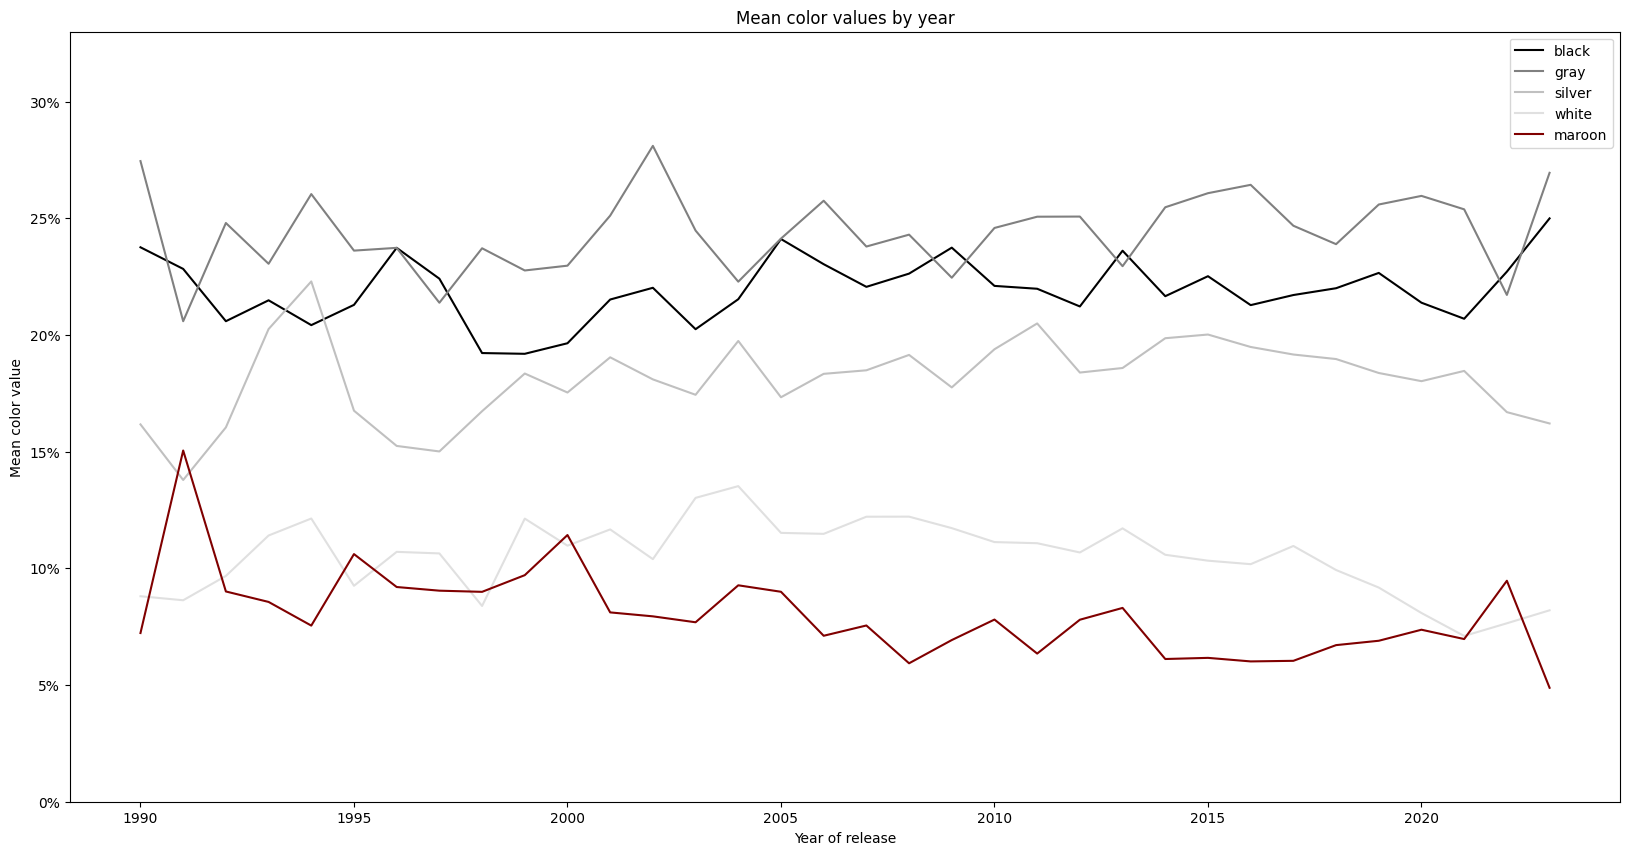

In [ ]:
used_cols = ['release_date', 'black', 'gray', 'silver', 'white', 'maroon']
line_colors = ['black','gray','silver', (0.88, 0.88, 0.88), 'maroon']
plot_colors_linechart(union_df, used_cols, line_colors, 1989, 0.33)

As we can see on the line charts for the average use of top five colors in different years, the use of colors in cover arts varies within plus or minus 5% over time in a wave-like pattern. There is no clear trend during the specified time frame. Nevertheless, subtle changes indicate that the use of maroon and white colors has slightly decreased in recent years, while the use of black color has, on the contrary, increased

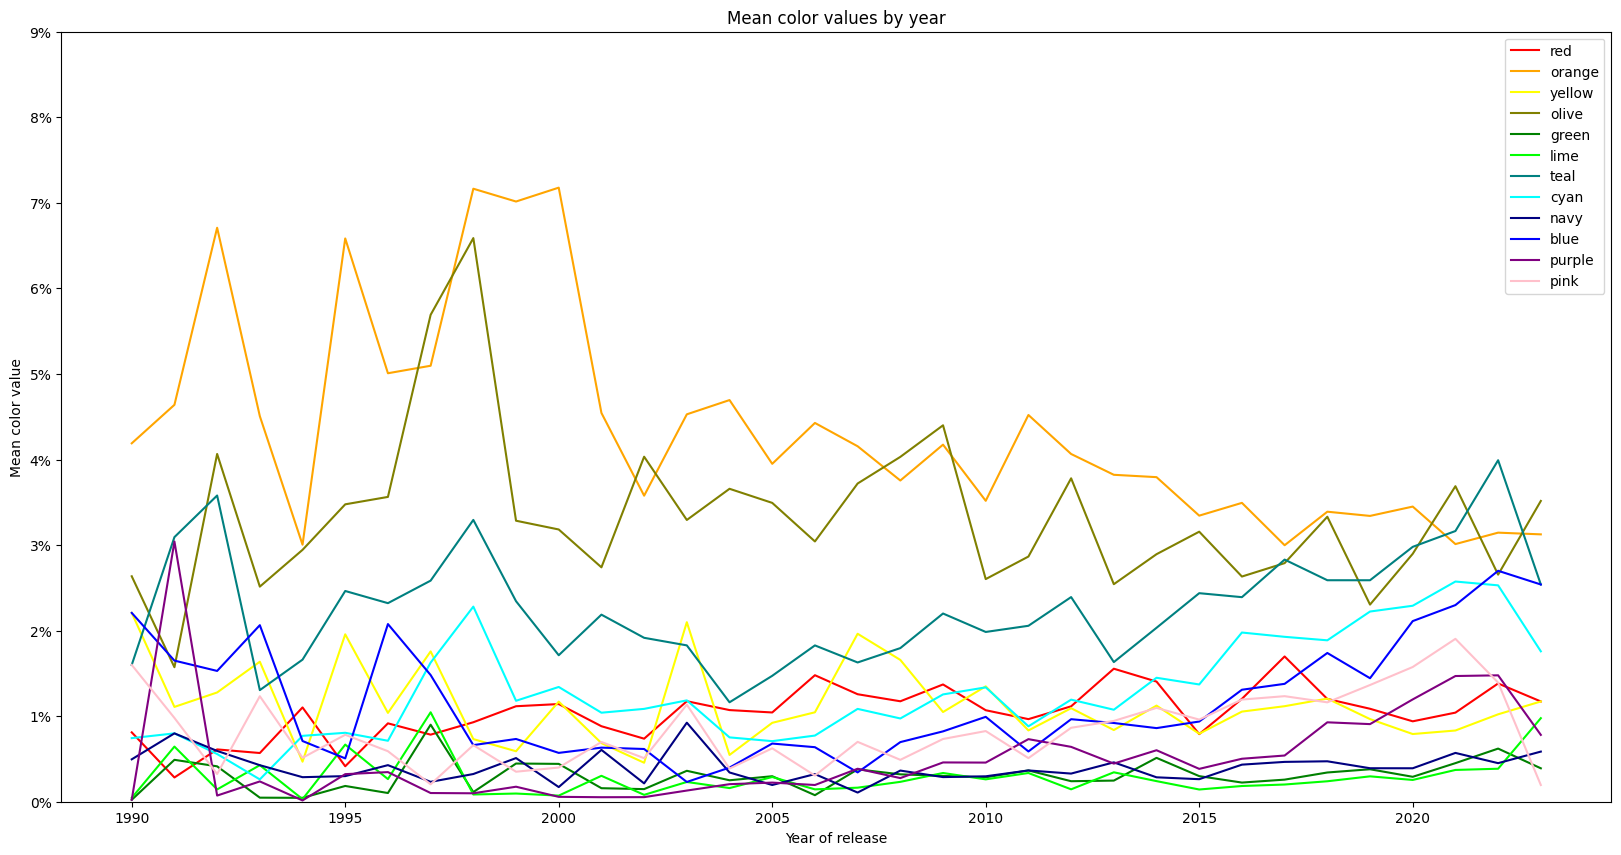

In [ ]:
used_cols = ['release_date', 'red', 'orange', 'yellow', 'olive',
         'green', 'lime', 'teal', 'cyan', 'navy', 'blue', 'purple', 'pink']
line_colors = ['red', 'orange', 'yellow', 'olive',
         'green', 'lime', 'teal', 'cyan', 'navy', 'blue', 'purple', 'pink']
plot_colors_linechart(union_df, used_cols, line_colors, 1989, 0.09)

The situation with the other colors is somewhat different. As can be seen from the graph for the remaining colors, their usage fluctuates greatly from 1990 to 2002, and then levels off slightly. During this period, the usage of these bright colors is 3-4% higher than in the later period. Orange is the most popular color, but it has been used less over time, while lime color has become more popular in recent years. The popularity of colors such as teal, blue, and purple, for example, has been increasing since 2004 until today, only declining in the last year.

Well, as the data shows, there is no significant trend in the use of colors in album covers over time, but there are minor fluctuations, which may be caused, for example, by the release of albums in a particular year with covers done mainly in one particular color, which pulls the average color content in the album cover color palette towards it.

In [8]:
import pandas as pd
from IPython.display import HTML
import math
import numpy as np

def path_to_image_html(path: str) -> str:
 
    # Create the HTML <img> tag with the specified path as the 'src' attribute and a width of 60 pixels
    html = '<img src="' + path + '" width="60" >'
    # Return the resulting HTML tag
    return html

def display_images_in_dataframe(df, col_name, num_cols=3):
    """
    Displays images from a DataFrame in a grid format in Jupyter Notebook
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the image URLs
    col_name (str): Name of the column containing the image URLs
    num_cols (int): Number of columns to display the images in (default 3)
    
    Returns:
    None
    """
    # Calculate the number of rows required to display all images
    num_rows = math.ceil(len(df) / num_cols)

    # Create a new DataFrame with the same shape as the final display grid
    data = np.empty((num_rows, num_cols), dtype=object)
    data[:] = np.nan
    temp_df = pd.DataFrame(data, columns=list(range(num_cols)))

    # Populate the new DataFrame with image HTML tags
    for i, url in enumerate(df[col_name]):
        row = i // num_cols
        col = i % num_cols
        temp_df.iloc[row, col] = path_to_image_html(url)

    # Format the HTML table for display in Jupyter Notebook
    html_table = temp_df.to_html(escape=False, index=False, header=False)

    # Display the HTML table
    display(HTML(html_table))


In [9]:
# Create a sample DataFrame with image URLs
df = pd.DataFrame({
    'cover': ['https://i.scdn.co/image/ab67616d00001e02b4bafae67d95046f07a9debd',
              'https://i.scdn.co/image/ab67616d00001e025bf251e9c75ad040ccc0abc6',
              'https://i.scdn.co/image/ab67616d00001e0218a8cbe3de3f3d60a9136a83',
              'https://i.scdn.co/image/ab67616d00001e025bf251e9c75ad040ccc0abc6',
              'https://i.scdn.co/image/ab67616d00001e025bf251e9c75ad040ccc0abc6',
              'https://i.scdn.co/image/ab67616d00001e02b4bafae67d95046f07a9debd',
              'https://i.scdn.co/image/ab67616d00001e0218a8cbe3de3f3d60a9136a83']
})

# Display the DataFrame with images inline
display_images_in_dataframe(df, 'cover', num_cols=3)


,,
,,
,NaN,NaN


In [10]:
def display_images_in_dataframe(df, col_name, num_cols=3):
    """
    Displays images from a DataFrame in a row format in Jupyter Notebook
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the image URLs
    col_name (str): Name of the column containing the image URLs
    num_cols (int): Number of columns to display the images in (default 3)
    
    Returns:
    None
    """
    # Create a list of image HTML tags
    images = [path_to_image_html(url) for url in df[col_name]]

    # Split the list of image HTML tags into sub-lists based on the number of columns
    sub_lists = [images[i:i+num_cols] for i in range(0, len(images), num_cols)]

    # Create a list of HTML rows, where each row is a concatenation of image HTML tags
    rows = ["".join(sub_list) for sub_list in sub_lists]

    # Join the list of HTML rows into a single string and wrap it in an HTML display object
    table = "<table><tr>{}</tr></table>".format("</tr><tr>".join(rows))
    display(HTML(table))



In [11]:
# Display the DataFrame with images inline
display_images_in_dataframe(df, 'cover', num_cols=3)